Downloading the ham emails from the the spamassassin's data sets.

In [ ]:
import pandas as pd 
from pathlib import Path
import tarfile
import urllib.request

def fetch_ham_data():
    # ham_root from spamassassin
    ham_root = "https://spamassassin.apache.org/old/publiccorpus/"
    ham_url = ham_root + "20030228_easy_ham.tar.bz2"
    ham_url_2 = ham_root + '20030228_easy_ham_2.tar.bz2'
    
    ham_path = Path() / ("../data/external")
    ham_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (('easy_ham', 'ham', ham_url), ('easy_ham_2', 'ham', ham_url_2)):
        
        if not (ham_path/dir_name).is_dir():
            path = (ham_path/tar_name).with_suffix('.tgz')
            urllib.request.urlretrieve(url, path)
            with tarfile.open(path) as tar_bz2_file:
                tar_bz2_file.extractall(path=ham_path)
    return [ham_path/dir_name for dir_name in ('easy_ham', 'easy_ham_2')]

In [2]:
ham_dir, ham_dir_2 = fetch_ham_data()

Downloading the phishing emails from rf-piexeto git hub account. This github account was referenced in the article "ChatSpamDetector: Leveraging Large LanguageModels for Effective Phishing Email Detection" read in arxiv. 

Since we only need the email files from that remote repository, we are going to use the git sparse check out command. It's is done in the command line, and if you are interested in how to do it, i've written an article on it, you can read it here.

In [3]:
# Using the iterdir() function we iterate over every files in the ham_dir and the phishing email and make
# them objects

ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
ham_2_filesnames = [f for f in sorted(ham_dir_2.iterdir()) if len(f.name) > 20][:20]

In [4]:
len(ham_filenames) , len(ham_2_filesnames)

(2500, 20)

In [6]:
import random

phishing_eml_path = Path("../data/external/phishing_email/email")
num_of_emails_to_select = 2500

# 1️⃣ Fix the seed so sampling becomes reproducible
random.seed(42)

all_phishing_filenames = [f for f in sorted(phishing_eml_path.iterdir())]
phishing_filenames = random.sample(all_phishing_filenames, num_of_emails_to_select)
other_fishing_filenames = [f for f in all_phishing_filenames if f not in phishing_filenames][:20]
len(phishing_filenames), len(other_fishing_filenames)



(2500, 20)

Creating a Parsing Mechanism using the email policy module in python. 

In [8]:
import email 
import email.policy

def load_email(filepath):
    with open(filepath, 'rb') as fp:
        return email.parser.BytesParser(policy=email.policy.default).parse(fp)
    
    #Read all the data from the binary file-like object fp, parse the resulting bytes,
    # and return the message object.fp must support both the readline() and the read() methods.

In [9]:
ham_emails = [load_email(file_path) for file_path in ham_filenames]
phishing_emails = [load_email(file_path) for file_path in phishing_filenames ]

In [83]:
print(type(ham_emails[0]))

<class 'email.message.EmailMessage'>


In [10]:
ham_2_emails = [load_email(file_path) for file_path in ham_2_filesnames ]
other_fishing_emails = [load_email(file_path) for file_path in other_fishing_filenames]

**Save the emails in a pickle file**

In [17]:
import pickle

processed_emails = [ham_emails, ham_2_emails, phishing_emails, other_fishing_emails]

path = Path("../data/processed")
with open(path/'email.pkl', 'wb') as file:
    pickle.dump(processed_emails, file)

In [ ]:
# Loading the emails
with open('../data/processed/email.pkl', 'rb' ) as file:
    emails = pickle.load(file)
    
# emails[0] = ham_emails
# emails[1] = ham_2_emails
# emails[2] = phishing_emails
# emails[3] = other_fishing_emails

In [18]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


Some emails are multiparts, i can't really figure out the form of some emails, so let's get the structure of each email

In [20]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ','.join([get_email_structure(subemail) for subemail in payload])
        return f'multipart({multipart})' # In case an email has multipart ( html, images)
    else:
        return email.get_content_type()

Let's create a counter, to count the type of structure found inside each email

In [21]:
from collections import Counter

def structure_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1 # Increament by one each time it sees thesame structure of an email
    return structures
        

In [22]:
structure_counter(ham_emails)

Counter({'text/plain': 2408,
         'multipart(text/plain,application/pgp-signature)': 66,
         'multipart(text/plain,text/html)': 8,
         'multipart(text/plain,text/plain)': 4,
         'multipart(text/plain)': 3,
         'multipart(text/plain,application/octet-stream)': 2,
         'multipart(text/plain,text/enriched)': 1,
         'multipart(text/plain,application/ms-tnef,text/plain)': 1,
         'multipart(multipart(text/plain,text/plain,text/plain),application/pgp-signature)': 1,
         'multipart(text/plain,video/mng)': 1,
         'multipart(text/plain,multipart(text/plain))': 1,
         'multipart(text/plain,application/x-pkcs7-signature)': 1,
         'multipart(text/plain,multipart(text/plain,text/plain),text/rfc822-headers)': 1,
         'multipart(text/plain,multipart(text/plain,text/plain),multipart(multipart(text/plain,application/x-pkcs7-signature)))': 1,
         'multipart(text/plain,application/x-java-applet)': 1})

In [23]:
structure_counter(phishing_emails)

Counter({'text/html': 1283,
         'multipart(text/plain,text/html)': 507,
         'multipart(text/html)': 316,
         'text/plain': 92,
         'multipart(text/html,image/jpeg,image/png,image/png,image/png)': 72,
         'multipart(multipart(text/html))': 34,
         'multipart(multipart(text/plain,text/html),application/pdf)': 28,
         'multipart(text/plain,application/pdf)': 20,
         'multipart(text/html,application/pdf)': 18,
         'multipart(text/html,text/plain)': 16,
         'multipart(multipart(multipart(text/plain,text/html)))': 8,
         'multipart(multipart(text/plain,text/html),application/octet-stream,application/octet-stream,application/octet-stream)': 8,
         'multipart/mixed': 8,
         'multipart(text/html,application/octet-stream)': 6,
         'multipart(multipart(text/plain,text/html),application/vnd.openxmlformats-officedocument.wordprocessingml.document)': 6,
         'multipart(text/plain,application/octet-stream)': 5,
         'multip

The majority of the emails in the phishing files are text/html, multipart(text/plain,text/html) infacts the other half pf the emails are multiparts. 

Let's look at the emails header. 

In [ ]:
for header, value in phishing_emails[11].items():
    print(header, ":", value)

According to the article "Building an Effective Email Spam Classification Model with spaCy", was interested in the textual content of the email. 

Because as we can see there are probably alot of information here. 

Also, while observing contents are written in different languuages. 

In [24]:
phishing_emails[11]['subject']

'Rp'

**Splitting into training and test set.**

In [26]:
import numpy as np 
from sklearn.model_selection import train_test_split
X = np.array(ham_emails + phishing_emails, dtype=object)
y = np.array([0]*len(ham_emails) + [1]*len(phishing_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
len(X_train[y_train==1]), len(X_train[y_train==0])

(2000, 2000)

**Let's create a function that convert html to plain text.**

In [28]:
from bs4 import BeautifulSoup
from html import unescape

def html_to_plain_text(html_email):
    # sample = email.get_content(), source of big errors, becasue html is already a string, so html_email.get_content gives an error because it is not an email 
    soup = BeautifulSoup(html_email, 'html.parser')
    
    # Remove the <head> section
    if soup.head:
        soup.head.decompose()
        
    #Replace the <a> tag by HYPERLINK
    for link in soup.find_all('a'):
        link.replace_with('HYPERLINK')
        
    #Get only the text form the email 
    text = soup.get_text()
    
    # clean up extra lines and spaces 
    cleaned_text = '\n'.join([line.strip() for line in text.splitlines() if line.strip()])
    
    return unescape(cleaned_text)

In [ ]:
html_phishing_email = [email for email in X_train[y_train==1] if get_email_structure(email) == 'multipart(application/pdf,multipart(text/html))']
sample = html_phishing_email[0]#multipart(text/html,image/jpeg,image/png,image/png,image/png) 'multipart(multipart(multipart(text/plain,text/html)))'
for part in sample.walk():
    print(part.get_content_type())
    
ham_email_zero = [email in email ]



multipart/alternative
application/pdf
multipart/alternative
text/html


**let's write a function that takes an email as input and returns its content as plain text, whatever its format is**

In [78]:
def email_to_text(email):
    html = None
    
     # Gives the format 
    for part in email.walk():
        ctype = part.get_content_type()
        
        # Skip subpart of multiparts not in ('text/html', 'text/plain'), so we'll not have to dealwith them becasue they don't have the get_content() method. 
        if ctype not in ('text/html', 'text/plain'):
            continue 
    
        try:
            content = part.get_content()
        except: # We 
            content = str(part.get_payload(decode=True))# This retrieves the raw payload bytes, and decode=True tries to: base64 decode
            # if isinstance(content, bytes):
            #     content = content.decode(errors="ignore") # convert bytes into string
                  
        if ctype == 'text/plain':
            return content
        else:
            html = content 
            
    if html:
        return html_to_plain_text(html)
    return ""  # fallback in case nothing is found


# print(email_to_text(sample))
print(email_to_text(ham_emails[19]))

Can someone explain what type of operating system Solaris is... as ive never
seen or used it i dont know wheather to get a server from Sun or from DELL i
would prefer a linux based server and Sun seems to be the one for that but
im not sure if Solaris is a distro of linux or a completely different
operating system? can someone explain...

Kiall Mac Innes


-- 
Irish Linux Users' Group: ilug@linux.ie
http://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.
List maintainer: listmaster@linux.ie




By trying to see the email text of the some emails i realized that english is not the only language. Let's use langdetect to detect the different kind of languages found inside the phishing_emails.

In [31]:
from langdetect import detect

def email_language(email):
    email_text = email_to_text(email)
    
    # If no text was extracted, use empty string instead of None
    if not email_text:
        return "unknown"
    
    try:
        return detect(email_text)
    except:
        return "unknown"


email_language(sample)

'en'

**Preprocessing Pipeline using spacy**

various pre-processing operations such as removal of stop words, removal of numbers, normalisation and stemming are performed on the dataset collected from the previous step using the spaCy tool. ref(Kazem Taghandiki, 2023.) in the article Building an Effective Email Spam Classification Model with spaCy

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
import re 
import urlextract
import spacy # Spacy is the open source library that enables the natural language understanding of each email content.



Following what (Kazem Taghandiki, 2023.) did;
- Tokenization
- removal of stop words, 
- removal of numbers, 
- normalization : which involves, lower cases, remove_punctuation.
- stemming and lemmatization



In [31]:
# Countunf the number of languages the are in te phishing emails.
from collections import Counter

# Count languages for all emails
lang_counts = Counter(email_language(email) for email in X_train[y_train == 1])
lang_counts



Counter({'en': 931,
         'pt': 321,
         'de': 303,
         'vi': 129,
         'fr': 112,
         'nl': 97,
         'unknown': 59,
         'es': 16,
         'pl': 5,
         'tr': 3,
         'ja': 3,
         'cy': 2,
         'no': 2,
         'id': 2,
         'sl': 2,
         'da': 2,
         'ko': 2,
         'sw': 1,
         'hr': 1,
         'lt': 1,
         'tl': 1,
         'ca': 1,
         'fi': 1,
         'sq': 1,
         'et': 1,
         'uk': 1})

In [76]:
interested_language =  ['en', 'pt', 'de', 'fr', 'nl', 'es']
# The rest of the languages will be translated into english. 

In [33]:
from deep_translator import GoogleTranslator

def translate_into_english(email):
    text = email_to_text(email)
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except:
        return text
    


In [34]:
spacy_models = {
    'en': 'en_core_web_sm',
    'fr': 'fr_core_news_sm',
    'de': 'de_core_news_sm',
    'pt': "pt_core_news_sm",
    'nl': "nl_core_news_sm",
    'es': "es_core_news_sm",
} # we don't use the vi because spacy has ot yet created a pipeline for that.

loaded_models = {lang: spacy.load(model) for lang, model in spacy_models.items()}
loaded_models

{'en': <spacy.lang.en.English at 0x1d795a30140>,
 'fr': <spacy.lang.fr.French at 0x1d796a875f0>,
 'de': <spacy.lang.de.German at 0x1d795a61070>,
 'pt': <spacy.lang.pt.Portuguese at 0x1d79ff536e0>,
 'nl': <spacy.lang.nl.Dutch at 0x1d79ff53920>,
 'es': <spacy.lang.es.Spanish at 0x1d79ebbac30>}

**I had this error when i first ran the emailtotoken class**

ValueError: [E088] Text of length 1337755 exceeds maximum of 1000000. The parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input. This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters, so you can check whether your inputs are too long by checking `len(text)`.

**Solution**
I went to chat gpt, they provided a max_chars varaible to truncate or reduce the len of the text. 

**I had this unicodeerror**

UnicodeEncodeError: 'utf-8' codec can't encode characters in position 0-1: surrogates not allowed Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...

meaning that the where word in some text that couldn't be encode by the utf-8 encoder, 

**Solution**

I asked chat gpt, it helped me create a clean text function, that sanitizes the text before passing it to spacy. 

In [35]:
# creating a transformer capable of preprocessing or parsing an email 

MAX_CHARS = 5000

def clean_text(text):
    """ sanitize the email text.
    encode: convert the python string into bytes. if there is a word that can't be encode it is been replace by (?)
    decode: convert the bytes back to string 
    """
    return text.encode("utf-8", "replace").decode("utf-8", "replace")


class EmailToTokens (BaseEstimator, TransformerMixin):
    def __init__(self, tokenization=True, strip_header=True, lower_case=True):
        self.strip_header = strip_header
        self.lower_case = lower_case
        self.tokenization = tokenization

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        all_tokens = []

        for email in X:
            tokens = []
            
            text = email_to_text(email) or ""
            
            # Clean unicode 
            text = clean_text(text)
            
            # Truncate long text
            if len(text) > MAX_CHARS:
                text = text[:MAX_CHARS]
            
            lang = email_language(email) or "en"

            if lang in loaded_models:
                nlp = loaded_models[lang]
            else:
                email = translate_into_english(email)
                lang = "en"
                nlp = spacy.load("en_core_web_sm")

            if self.lower_case:
                text = text.lower()

            # if not self.tokenization:
            #     all_tokens.append(text)
            #     continue
            
            doc = nlp(text)

            for token in doc:
                # Replace URLs
                if token.like_url:
                    tokens.append("URL")
                    continue

                # Skip pure numbers
                if token.like_num or token.text.isdigit():
                    continue

                # Mixed alphanumeric: keep only letters
                if re.search(r"[A-Za-z]", token.text) and re.search(r"\d", token.text):
                    cleaned = re.sub(r"\d", "", token.text)
                    tokens.append(cleaned.lower())
                    continue

                # Skip punctuation, symbols, stop words
                if token.is_punct or token.is_stop or not token.is_alpha:
                    continue
                
                # Lemma
                lemma = token.lemma_.strip()
                if lemma:
                    tokens.append(lemma)

            all_tokens.append(tokens)

        return all_tokens

**(Text Representation), converting tokens → numbers.**

**Machine learning models do not understand text, they always ask for numbers. For this reason we are going to convert this tokens to vectors number using the TfidVectorizer.**

**Checking how the vectorizer behave**

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer=lambda tokens: tokens,   # <-- VERY important
    lowercase=False,                  # tokens already processed
    token_pattern=None                # disable default tokenizer
)
sample_output = X_train[:4]
sample_output_vector = vectorizer.fit_transform(sample_output)
print(vectorizer.vocabulary_)

{'Received': 24, 'ARC-Seal': 2, 'ARC-Message-Signature': 1, 'ARC-Authentication-Results': 0, 'Authentication-Results': 3, 'Received-SPF': 25, 'X-IncomingTopHeaderMarker': 36, 'Authentication-Results-Original': 4, 'Content-Type': 7, 'From': 11, 'To': 29, 'Subject': 28, 'Message-ID': 21, 'Date': 8, 'X-ClientProxiedBy': 31, 'Return-Path': 26, 'X-MS-TrafficTypeDiagnostic': 67, 'X-MS-Office365-Filtering-Correlation-Id': 64, 'X-MS-Exchange-SenderADCheck': 59, 'X-MS-Exchange-AntiSpam-Relay': 39, 'X-Microsoft-Antispam-Untrusted': 78, 'X-Microsoft-Antispam-Message-Info-Original': 77, 'X-Forefront-Antispam-Report-Untrusted': 34, 'X-MS-Exchange-AntiSpam-MessageData-Original-ChunkCount': 38, 'X-MS-Exchange-AntiSpam-MessageData-Original-0': 37, 'X-MS-Exchange-Transport-CrossTenantHeadersStamped': 61, 'X-IncomingHeaderCount': 35, 'X-MS-Exchange-Organization-ExpirationStartTime': 52, 'X-MS-Exchange-Organization-ExpirationStartTimeReason': 53, 'X-MS-Exchange-Organization-ExpirationInterval': 50, 'X-MS

**Preprocessing_Pipeline**

The TfidVectorizer expect strings to tokenize it but out email to tokens() class already did the job, so we have to create an identity function to specify to TfidVectorizer that, just take tokens as it is and just computes the TF-IDF weights of the tokens.

**Error Prevention**

It prevent the PicklingError: Can't pickle <function <lambda> at 0x000002D2999E8400>: it's not found as __main__.<lambda> error. Becasue when creating a pkl file, it serialize your model, but when you call it shoul d be able un serializeit in production. 

In [37]:
# it is a function that return exactly what it takes.
def identity(tokens):
    return(tokens)

In [ ]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_tokens", EmailToTokens()),
    ("tokens_vector", TfidfVectorizer(
    analyzer=lambda tokens: tokens,   # <-- VERY important
    lowercase=False,                  # tokens already processed
    token_pattern=None                # disable default tokenizer
))
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# Transform test using the same pipeline (do NOT fit again)
X_test_transforme = preprocess_pipeline.transform(X_test)

In [152]:
X_train_transformed.shape

(4000, 32639)

In [153]:
X_test_transforme

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 50263 stored elements and shape (1000, 32639)>

**Training Models**

- Naives Based
- Logistic Regression
- linear SVM 

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


**Training models and evaluating using cross_validation**

In [138]:
models = {'log_clf': LogisticRegression(max_iter=1000, random_state=42), 
          'svc_clf':LinearSVC(C=0.1, dual=False, max_iter=1000),
          'naive_clf': MultinomialNB()}

scoring = {
    'accuracy':'accuracy',
    'recall': make_scorer(recall_score),
    'precision':make_scorer(precision_score)
}
all_results={}
for name, model in models.items(): 
    results = cross_validate(model, X_train_transformed, y_train, cv=5, scoring=scoring)
    all_results[name] = results 
    
# Example: print results for LogisticRegression
print("Keys in results for log_clf:", all_results['log_clf'].keys())
    

Keys in results for log_clf: dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_recall', 'test_precision'])


In [139]:
all_results

{'log_clf': {'fit_time': array([0.21511936, 0.15001321, 0.15169001, 0.14358044, 0.14143157]),
  'score_time': array([0.00503087, 0.00736833, 0.00779724, 0.00500226, 0.01002431]),
  'test_accuracy': array([0.9875 , 0.9775 , 0.98875, 0.99375, 0.98875]),
  'test_recall': array([0.9775, 0.9575, 0.9825, 0.9875, 0.9775]),
  'test_precision': array([0.99744898, 0.99739583, 0.99493671, 1.        , 1.        ])},
 'svc_clf': {'fit_time': array([0.10994101, 0.08484721, 0.0810833 , 0.06811619, 0.07779813]),
  'score_time': array([0.01533842, 0.01526737, 0.00346541, 0.00500083, 0.0113728 ]),
  'test_accuracy': array([0.99   , 0.98   , 0.98875, 0.99375, 0.99125]),
  'test_recall': array([0.9825, 0.9625, 0.9825, 0.9875, 0.9825]),
  'test_precision': array([0.99746193, 0.99740933, 0.99493671, 1.        , 1.        ])},
 'naive_clf': {'fit_time': array([0.00680995, 0.00346994, 0.00456905, 0.00598598, 0.00724697]),
  'score_time': array([0.00760603, 0.01326847, 0.00502992, 0.00658965, 0.00347757]),
  '

In [142]:
for model, key in all_results.items():
    print(f'Average time of {model}, {key['fit_time'].mean()}')
    print(f'Average accuracy of {model}, {key['test_accuracy'].mean()}')
    print(f'Average precision of {model}, {key['test_precision'].mean()}')
    print(f'Average recall of {model}, {key['test_recall'].mean()}')
    

Average time of log_clf, 0.16036691665649414
Average accuracy of log_clf, 0.9872500000000001
Average precision of log_clf, 0.997956304357186
Average recall of log_clf, 0.9765
Average time of svc_clf, 0.0843571662902832
Average accuracy of svc_clf, 0.9887499999999999
Average precision of svc_clf, 0.997961592843928
Average recall of svc_clf, 0.9795
Average time of naive_clf, 0.005616378784179687
Average accuracy of naive_clf, 0.9570000000000001
Average precision of naive_clf, 0.9994579945799458
Average recall of naive_clf, 0.9145000000000001


**The two best models are logistic and support vector machine models**

In [39]:
from sklearn.pipeline import Pipeline

log_full_pipeline = Pipeline([
    ('tokens', EmailToTokens()),
    ("tokens_vector", TfidfVectorizer(
    analyzer=identity,   # <-- VERY important
    lowercase=False,                  # tokens already processed
    token_pattern=None )),
    ('log_clf', LogisticRegression(max_iter=1000, random_state=42))   
])

svc_full_pipeline = Pipeline([
    ('tokens', EmailToTokens()),
    ("tokens_vector", TfidfVectorizer(
    analyzer=identity,   # <-- VERY important
    lowercase=False,                  # tokens already processed
    token_pattern=None )),
    ('svc_clf', LinearSVC(C=0.1, dual=False, max_iter=1000))   
])

In [40]:
log_training = log_full_pipeline.fit(X_train, y_train)

In [41]:
log_y_pred = log_training.predict(X_test)

In [42]:
log_y_pred

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,

In [43]:
log_precision = precision_score(y_test, log_y_pred)
log_recall = recall_score(y_test, log_y_pred)
log_precision, log_recall

(0.9979423868312757, 0.97)

In [46]:
svc_training = svc_full_pipeline.fit(X_train, y_train)

In [47]:
svc_y_pred = svc_training.predict(X_test)

In [49]:
svc_precision = precision_score(y_test, svc_y_pred)
svc_recall = recall_score(y_test, svc_y_pred)
svc_precision, svc_recall

(0.9979508196721312, 0.974)

**This comparison code is all produced by my friend Chatgpt**

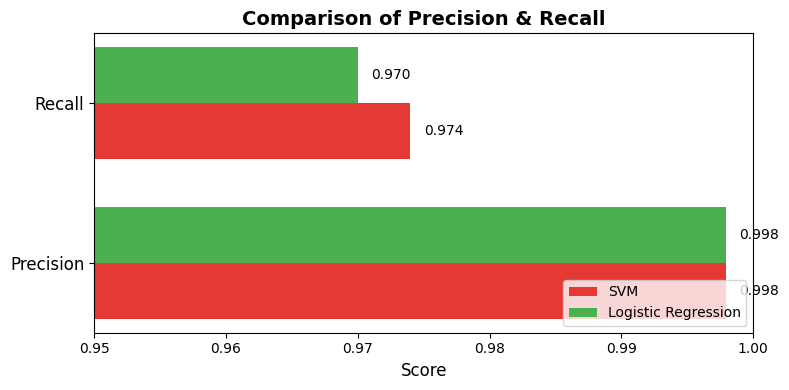

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and scores
metrics = ["Precision", "Recall"]
svm_values = [svc_precision, svc_recall]
log_values = [log_precision, log_recall]

# Settings
bar_height = 0.35
y = np.arange(len(metrics))  # positions for metrics

fig, ax = plt.subplots(figsize=(8, 4))  # wider figure for spacing

# Horizontal bars
ax.barh(y - bar_height/2, svm_values, height=bar_height, color="#E53935", label="SVM")
ax.barh(y + bar_height/2, log_values, height=bar_height, color="#4CAF50", label="Logistic Regression")

# Labels and title
ax.set_yticks(y)
ax.set_yticklabels(metrics, fontsize=12)
ax.set_xlim(0.95, 1.0)  # zoom in on high values for clarity
ax.set_xlabel("Score", fontsize=12)
ax.set_title("Comparison of Precision & Recall", fontsize=14, fontweight="bold")
ax.legend(loc="lower right")

# Annotate values on bars
for i in range(len(metrics)):
    ax.text(svm_values[i] + 0.001, y[i] - bar_height/2, f"{svm_values[i]:.3f}", va="center", fontsize=10)
    ax.text(log_values[i] + 0.001, y[i] + bar_height/2, f"{log_values[i]:.3f}", va="center", fontsize=10)

plt.tight_layout()
plt.savefig("../reports/figures/evaluation_comparison.png", bbox_inches="tight")
plt.show()


**Confusion Matrix**

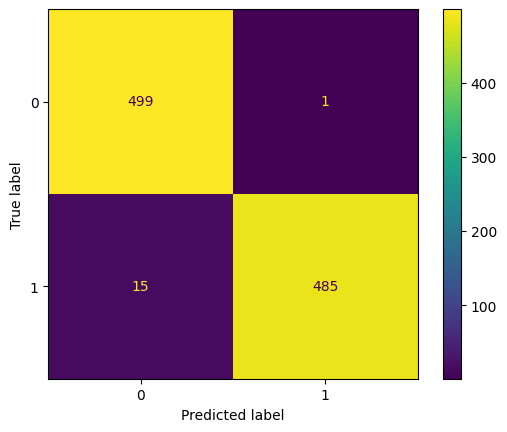

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test, log_y_pred)
plt.savefig("../reports/figures/logistic_confusion_matrix.png", bbox_inches="tight")
plt.show()


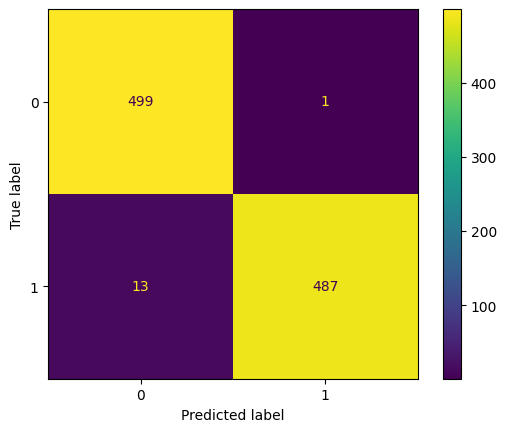

In [92]:

ConfusionMatrixDisplay.from_predictions(y_test, svc_y_pred)
plt.savefig("../reports/figures/svm_confusion_matrix.png", bbox_inches="tight")
plt.show()

**Checking if it classifies correctly the other fishing emails**

In [81]:
ham_2_emails[0]

In [65]:
new_ham_prediction = log_training.predict(ham_2_emails)
new_svc_ham_pred = svc_training.predict(ham_2_emails)
new_ham_prediction, new_svc_ham_pred

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

**Save the models**

In [ ]:
import joblib

file_path = Path('../models')
log_file_name = file_path/('logistic_regression_classifier.pkl')
joblib.dump(log_training, open(log_file_name, 'wb'))

In [48]:
# Saving the support vector model.
file_path = Path('../models')
svc_file_name = file_path/('support_vector_classifier.pkl')
joblib.dump(svc_training, open(svc_file_name, 'wb'))